# Training RSTAE

This notebook shows how to train the anomaly detection model.

In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import RelationalSTAE
from parameters import RSTAEParameters, TrainingParameters
from datautils import get_morning_data, get_rstae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_rstae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Time Series Sequencing

In [2]:
def sequence_rstae(data, timesteps, hide_anomalies=True):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not

        node_data = np.concatenate(data_t[::-1])
        pyg_data = Data(x=torch.tensor(node_data, dtype=torch.float32), edge_index=relational_edges, edge_attr=torch.tensor(relations, dtype=torch.long))
        
        # curr_data = data_t[-1]
        curr_data = data_t[0]
        
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append([pyg_data, curr_graph])

    return sequence, kept_indices

### Loading Hyperparameters

In [3]:
optimal_hyperparams = load_best_parameters('rstae')

In [4]:
optimal_hyperparams

{'dropout': 0.4520153916756675,
 'epochs': 9,
 'gcn_hidden_dim': 128,
 'latent_dim': 32,
 'learning_rate': 0.0016636923544942992,
 'num_gcn': 1,
 'timesteps': 8}

In [5]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [6]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=optimal_hyperparams['timesteps'],
    n_epochs=1
)

In [7]:
train_data, test_data, _ = get_full_data()
train_data = normalize_data(train_data)
train_data = label_anomalies(train_data)
train_sequence, kept_train_indices = sequence_rstae(train_data, training_params.timesteps)

100%|██████████| 13432/13432 [12:42<00:00, 17.61it/s]


In [8]:
hyperparams = RSTAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    dropout=optimal_hyperparams['dropout'],
    num_gcn=optimal_hyperparams['num_gcn']
)

In [9]:
ae = RelationalSTAE(hyperparams)

In [10]:
ae(train_sequence[0][0]).shape

torch.Size([196, 3])

### Model Training or Loading

In [11]:
using_pretrained = True

In [12]:
if not using_pretrained:
    ae, losses = train_rstae(rstaeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, 'rstae')
else:
    ae = load_model(RelationalSTAE, hyperparams, 'rstae')

100%|██████████| 1/1 [01:19<00:00, 79.69s/it]

Epoch number 0 last 100 loss 0.009847864273469896


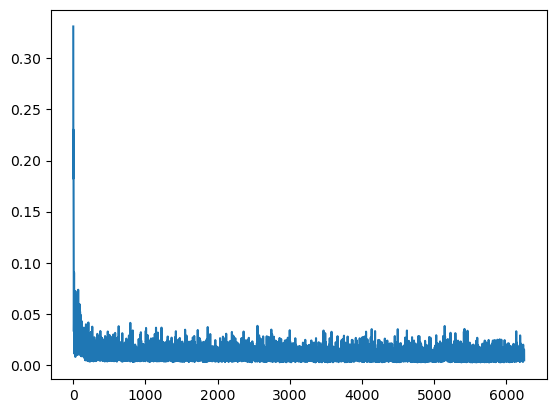

In [13]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [14]:
thresh = compute_anomaly_threshold_rstae(train_sequence, ae, mse_weights, 'max')

100%|██████████| 6246/6246 [00:51<00:00, 122.03it/s]


### Loading Test Data

In [15]:
_, df_test_data, _ = get_full_data()

In [16]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_rstae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4792/4792 [02:10<00:00, 36.73it/s]


In [17]:
test_errors, test_recons_speeds, test_true_speeds = test_rstae(test_data, mse_weights, ae)

In [18]:
np.mean(test_errors)

0.013414989

In [19]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/home/austinc/projects/traffic-anomaly/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1


/home/austinc/projects/traffic-anomaly/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


### Compute FPR / Crash Detection Delay Tradeoff

In [20]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 98/98 [00:02<00:00, 47.55it/s]


In [21]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/rstae_fp_delay.csv')

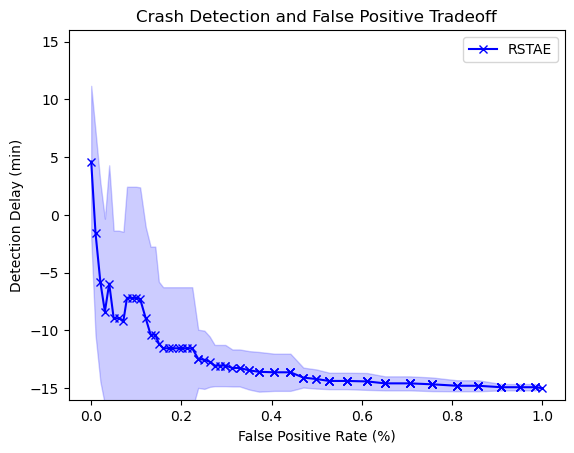

In [22]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='RSTAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [23]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [01:45<00:00,  9.47it/s]

FPR 1% gives mean delay of -1.5625 +/- 8.829770311282168 while missing 0.33333333333333337%.
FPR 2.5% gives mean delay of -5.8125 +/- 8.62024325352829 while missing 0.33333333333333337%.
FPR 5% gives mean delay of -8.95 +/- 7.590948557327996 while missing 0.16666666666666663%.
FPR 10% gives mean delay of -7.181818181818182 +/- 9.620699103478364 while missing 0.08333333333333337%.
FPR 20% gives mean delay of -11.545454545454545 +/- 5.284860647748028 while missing 0.08333333333333337%.


### Compute AUC

In [24]:
calculate_auc(test_errors, anomaly_labels)

0.6666358794372095

### Copmute Detection Delay Histogram on Full Dataset

In [25]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [26]:
full_sequence, kept_full_indices = sequence_rstae(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 0/18232 [00:00<?, ?it/s]

100%|██████████| 18232/18232 [28:51<00:00, 10.53it/s]


In [27]:
full_errors, _, _ = test_rstae(full_sequence, mse_weights, ae)

In [28]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

/home/austinc/projects/traffic-anomaly/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [29]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


In [30]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


In [31]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

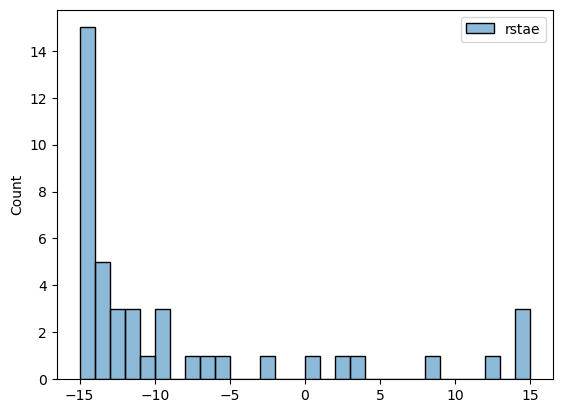

In [32]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='rstae')
plt.legend()

In [33]:
np.save('./saved_results/rstae10delays.npy', np.array(delay)/2)

In [39]:
_, df_clean_test_data, _ = get_full_data()

In [40]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_rstae(clean_test_data, training_params.timesteps, hide_anomalies=True)

100%|██████████| 4792/4792 [01:24<00:00, 56.47it/s] 


In [41]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_rstae(clean_test_data, mse_weights, ae)

In [42]:
np.mean(clean_test_errors)

0.010208633

In [34]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [35]:
# data.to_csv('./saved_results/full_results_test_rstae.csv')

In [36]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_rstae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [37]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [38]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()